# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f7c6fb5f198>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/tetra_one_species.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['max_subunits', 4]
Using multiGraph
['A']
Parsing rule...
['A(a)+A(a)<->A(a!1).A(a!1)', 'G=-20']
['A', 'A', '']
['A(a)+A(a)', 'A(a!1).A(a!1)']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f7c6c34def0>, 'copies': tensor([200.], dtype=torch.float64)})
Node-2 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f7c6c34def0>, 'copies': tensor([200.], dtype=torch.float64)})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Adding another subunit
Allowed edges: 
('A', 'A')
############################3
[]
New node added--1
['A']
Adding an new edge-- 0 1
New bonds:  [('A', 'A')]
Adding an new edge-- 0 1
New node added--2
[0, 1]
Trying internal bonds
Allowed edges: 
('A', 'A')
############################3
[(1, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f7bd9f7a128>, 'copies': tensor([0.], dtype=torch.float64)})]
Node-1 :  (1, {'struct': <networkx.classes.multigraph.MultiGraph object at 

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n)
    print(gtostr(rn.network.nodes()[n]['struct']))
    for k,v in rn.network[n].items():
        print(v)
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)


0
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
1
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
2
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
3
A
{(0, 1): 0, (0, 2): 1, (0, 3): 2, (1, 2): 1, (2, 3): 2}


A -- 0
[]
AA -- 1
[('A', 'A')]
AAA -- 2
[('A', 'A'), ('A', 'A')]
AAAAA -- 3
[('A', 'A'), ('A', 'A'), ('A', 'A'), ('A', 'A')]
{2: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}}


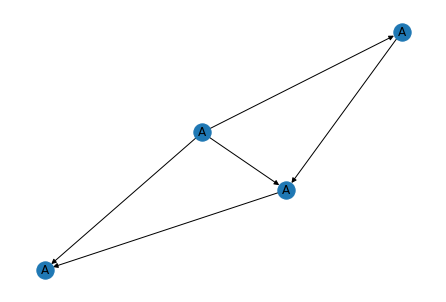

In [5]:
import networkx as nx
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
nx.draw(rn.network, labels=labels)

for node in rn.network.nodes(data=True):
    st = gtostr(node[1]['struct'])
    n_edges = node[1]['struct'].number_of_edges()
#     st1 = [set(i) for i in node[1]['struct'].edges()]
#     a=[]
#     for i in st1:
#         a+=list(i) 
    
    if n_edges >= len(set(st)):
        st= st+n_edges*st
    print(st,"--",node[0])
#     print("".join(a), "--",node[0])
    print(node[1]['struct'].edges())
    
print(rn.network[1]) 

In [6]:
# def _equal(n1, n2) -> bool:
#     """
#     Test whether two structures have identical connectivity
#     :param n1: nx.Graph
#     :param n2: nx.Graph
#     :return: Boolean indicating whether or not graphs are equal
#     """
#     nm = nx.algorithms.isomorphism.categorical_node_match("label", None)
#     int_n1 = nx.convert_node_labels_to_integers(n1, label_attribute="label")
#     int_n2 = nx.convert_node_labels_to_integers(n2, label_attribute="label")
#     print(int_n1)
#     print(int_n2)
#     return nx.is_isomorphic(int_n1, int_n2, node_match=nm)

# repeat_units=False
# import networkx as nx
# for i in range(len(rn.network.nodes)):
#     for (u,v) in rn.network.nodes[i]['struct'].edges:
#         if u==v:
#             repeat_units=True
#             print(repeat_units)
#         print(u,v)
#     print(i)

# # orig = rn.network.nodes[0]['struct']
# # orig = nx.relabel_nodes(orig,{'A':'AA'})
# # orig.add_edge('A','AA')
# # print(orig.nodes.data)

# # print(orig.nodes)

# # node_exists = [x for x in rn.network.nodes(data=True) if
# #                        _equal(x[1]['struct'], orig)]

# # print(node_exists)

In [7]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1.0,1.0,1.0]*np.array([1e0])  #Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 2}
A
Reactant

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [8]:
# vec_rn.update_reaction_net(rn,1)
# poly_system = EquilibriumSolver(rn)
# solution = poly_system.solve()
# if solution == None:
#     print("No Equilibrium solution")
# else:
#     print(solution)
#     print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
# print(vec_rn.kon)

In [9]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# for n in rn.network.nodes():
#     #print(n)
#     #print(rn.network.nodes()[n])
#     for k,v in rn.network[n].items():
#         uid = v['uid']
#         r1 = set(gtostr(rn.network.nodes[n]['struct']))
#         p = set(gtostr(rn.network.nodes[k]['struct']))
#         r2 = p-r1
#         reactants = (r1,r2)
#         uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
#         if uid not in uid_dict.keys():
#             uid_dict[uid] = uid_val
#     print(gtostr(rn.network.nodes[n]['struct']))
#     #for r_set in rn.get_reactant_sets(n):
#     #    print(tuple(r_set))
#     #print(rn.network[n]['struct'])
# ind_sort = np.argsort(vec_rn.kon.detach().numpy())
# for i in ind_sort:
#     print(vec_rn.kon[i])
#     print(uid_dict[i])

In [10]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor
# import torch

# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         if len(edges)==0:
#             return(False)
#         kon_max = -1
#         next_node = -1
        
#         kon_sum = 0
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']
#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*solution[edge[1]] - temp_kon*(solution[edge[0]])*(solution[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Free Energy: ",vec_rn.rxn_score_vec[uid])
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(solution[edge[0]])*(solution[node_map[react]])- koff*solution[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}

# if solution != None:
#     for n in rn.network.nodes():

#         n_str = gtostr(rn.network.nodes[n]['struct']) 

#         paths = [n_str]
#         kon_sum = 0
#         temp_node = n
#         max_edge = True
#         consumption_rate = 0
#         if n < len(rn.network.nodes()):#num_monomers:
#     #         print("Current node: ")
#     #         print(n_str)
#             while max_edge:
#                 max_edge = get_max_edge(temp_node)
#                 if max_edge:
#                     total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
#                     temp_node = max_edge[1]
#                     kon_sum += max_edge[0].item()


#     #                 print("Next node: ")
#     #                 print(temp_node)

#                     paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#                 else:
#                     break
#             pathway.append(paths)
#             kon_sumarray.append(kon_sum)
#             paths=[]

#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")
#         print("|                                                                             |")
#         node_flux = get_node_flux(n)
#         net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#         print("|                                                                             |")
#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")

#     print(pathway)
#     print(kon_sumarray)
#     #print(total_con_rate)

In [11]:
# if solution != None:
#     for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#         print(k," : ", v.item())

In [12]:
# if solution !=None:
#     for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#         print(k," : ", v)



## Using the optimizer with a 1 second simulation runtime ##

In [13]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=5000,
                  learning_rate=new_kon[0]/1e3,
                  device='cpu',method="RMSprop")
optim.rn.update_reaction_net(rn)
optim.optimize()

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1., 1.], dtype=torch.float64, requires_grad=True)]
Using CPU
Next time:  tensor(13.3742, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 0 was 6.44%
current params: tensor([0.9900, 1.0100, 1.0100], dtype=torch.float64)
Using CPU
Next time:  tensor(13.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1 was 6.56%
current params: tensor([0.9828, 1.0171, 1.0171], dtype=torch.float64)
Using CPU
Next time:  tensor(13.8968, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2 was 6.64%
current params: tensor([0.9769, 1.0228, 1.0229], dtype=torch.float64)
Using CPU
Next time:  tensor(14.1049, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation

Using CPU
Next time:  tensor(17.8275, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 34 was 7.89%
current params: tensor([0.8789, 1.1151, 1.1145], dtype=torch.float64)
Using CPU
Next time:  tensor(17.8309, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 35 was 7.89%
current params: tensor([0.8789, 1.1152, 1.1149], dtype=torch.float64)
Using CPU
Next time:  tensor(17.8343, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 36 was 7.89%
current params: tensor([0.8788, 1.1152, 1.1153], dtype=torch.float64)
Using CPU
Next time:  tensor(17.8378, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 37 was 7.90%
current params: tensor([0.8787, 1.1153, 1.1157], dtype=torch.float64)


Next time:  tensor(17.9552, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 68 was 7.97%
current params: tensor([0.8756, 1.1171, 1.1282], dtype=torch.float64)
Using CPU
Next time:  tensor(17.9594, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 69 was 7.97%
current params: tensor([0.8755, 1.1171, 1.1286], dtype=torch.float64)
Using CPU
Next time:  tensor(17.9636, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 70 was 7.97%
current params: tensor([0.8754, 1.1172, 1.1290], dtype=torch.float64)
Using CPU
Next time:  tensor(17.9678, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 71 was 7.98%
current params: tensor([0.8753, 1.1173, 1.1295], dtype=torch.float64)
Using CPU


Next time:  tensor(18.1110, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 102 was 8.06%
current params: tensor([0.8716, 1.1194, 1.1437], dtype=torch.float64)
Using CPU
Next time:  tensor(18.1161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 103 was 8.07%
current params: tensor([0.8715, 1.1195, 1.1442], dtype=torch.float64)
Using CPU
Next time:  tensor(18.1212, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 104 was 8.07%
current params: tensor([0.8714, 1.1195, 1.1447], dtype=torch.float64)
Using CPU
Next time:  tensor(18.1263, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 105 was 8.07%
current params: tensor([0.8713, 1.1196, 1.1452], dtype=torch.float64)
Using 

Next time:  tensor(18.2955, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 135 was 8.17%
current params: tensor([0.8670, 1.1220, 1.1607], dtype=torch.float64)
Using CPU
Next time:  tensor(18.3017, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 136 was 8.17%
current params: tensor([0.8669, 1.1221, 1.1612], dtype=torch.float64)
Using CPU
Next time:  tensor(18.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 137 was 8.17%
current params: tensor([0.8667, 1.1222, 1.1618], dtype=torch.float64)
Using CPU
Next time:  tensor(18.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 138 was 8.18%
current params: tensor([0.8666, 1.1223, 1.1623], dtype=torch.float64)
Using 

Next time:  tensor(18.5209, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 168 was 8.28%
current params: tensor([0.8615, 1.1252, 1.1795], dtype=torch.float64)
Using CPU
Next time:  tensor(18.5285, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 169 was 8.29%
current params: tensor([0.8613, 1.1253, 1.1801], dtype=torch.float64)
Using CPU
Next time:  tensor(18.5361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 170 was 8.29%
current params: tensor([0.8611, 1.1254, 1.1807], dtype=torch.float64)
Using CPU
Next time:  tensor(18.5438, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 171 was 8.30%
current params: tensor([0.8609, 1.1255, 1.1813], dtype=torch.float64)
Using 

Next time:  tensor(18.7975, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 201 was 8.42%
current params: tensor([0.8549, 1.1289, 1.2003], dtype=torch.float64)
Using CPU
Next time:  tensor(18.8069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 202 was 8.42%
current params: tensor([0.8547, 1.1291, 1.2009], dtype=torch.float64)
Using CPU
Next time:  tensor(18.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 203 was 8.43%
current params: tensor([0.8544, 1.1292, 1.2016], dtype=torch.float64)
Using CPU
Next time:  tensor(18.8257, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 204 was 8.43%
current params: tensor([0.8542, 1.1293, 1.2022], dtype=torch.float64)
Using 

Next time:  tensor(19.1609, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 235 was 8.58%
current params: tensor([0.8468, 1.1334, 1.2234], dtype=torch.float64)
Using CPU
Next time:  tensor(19.1727, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 236 was 8.58%
current params: tensor([0.8466, 1.1335, 1.2241], dtype=torch.float64)
Using CPU
Next time:  tensor(19.1846, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 237 was 8.59%
current params: tensor([0.8463, 1.1337, 1.2248], dtype=torch.float64)
Using CPU
Next time:  tensor(19.1965, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 238 was 8.59%
current params: tensor([0.8460, 1.1338, 1.2255], dtype=torch.float64)
Using 

Next time:  tensor(19.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 268 was 8.75%
current params: tensor([0.8372, 1.1388, 1.2477], dtype=torch.float64)
Using CPU
Next time:  tensor(19.6102, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 269 was 8.76%
current params: tensor([0.8368, 1.1390, 1.2485], dtype=torch.float64)
Using CPU
Next time:  tensor(19.6250, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 270 was 8.76%
current params: tensor([0.8365, 1.1392, 1.2492], dtype=torch.float64)
Using CPU
Next time:  tensor(19.6400, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 271 was 8.77%
current params: tensor([0.8362, 1.1394, 1.2500], dtype=torch.float64)
Using 

Next time:  tensor(20.1567, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 302 was 8.96%
current params: tensor([0.8252, 1.1455, 1.2742], dtype=torch.float64)
Using CPU
Next time:  tensor(20.1752, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 303 was 8.97%
current params: tensor([0.8249, 1.1457, 1.2750], dtype=torch.float64)
Using CPU
Next time:  tensor(20.1939, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 304 was 8.97%
current params: tensor([0.8245, 1.1459, 1.2758], dtype=torch.float64)
Using CPU
Next time:  tensor(20.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 305 was 8.98%
current params: tensor([0.8241, 1.1461, 1.2766], dtype=torch.float64)
Using 

Next time:  tensor(20.8650, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 336 was 9.20%
current params: tensor([0.8110, 1.1533, 1.3021], dtype=torch.float64)
Using CPU
Next time:  tensor(20.8884, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 337 was 9.20%
current params: tensor([0.8105, 1.1535, 1.3029], dtype=torch.float64)
Using CPU
Next time:  tensor(20.9121, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 338 was 9.21%
current params: tensor([0.8101, 1.1538, 1.3038], dtype=torch.float64)
Using CPU
Next time:  tensor(20.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 339 was 9.22%
current params: tensor([0.8096, 1.1541, 1.3046], dtype=torch.float64)
Using 

Next time:  tensor(21.7624, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 369 was 9.46%
current params: tensor([0.7944, 1.1624, 1.3302], dtype=torch.float64)
Using CPU
Next time:  tensor(21.7927, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 370 was 9.47%
current params: tensor([0.7938, 1.1627, 1.3311], dtype=torch.float64)
Using CPU
Next time:  tensor(21.8231, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 371 was 9.48%
current params: tensor([0.7933, 1.1630, 1.3320], dtype=torch.float64)
Using CPU
Next time:  tensor(21.8538, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 372 was 9.49%
current params: tensor([0.7927, 1.1633, 1.3328], dtype=torch.float64)
Using 

Next time:  tensor(22.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 402 was 9.76%
current params: tensor([0.7748, 1.1732, 1.3592], dtype=torch.float64)
Using CPU
Next time:  tensor(22.9238, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 403 was 9.77%
current params: tensor([0.7742, 1.1735, 1.3601], dtype=torch.float64)
Using CPU
Next time:  tensor(22.9624, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 404 was 9.78%
current params: tensor([0.7735, 1.1739, 1.3610], dtype=torch.float64)
Using CPU
Next time:  tensor(23.0014, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 405 was 9.79%
current params: tensor([0.7729, 1.1743, 1.3619], dtype=torch.float64)
Using 

Next time:  tensor(24.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 435 was 10.1%
current params: tensor([0.7520, 1.1858, 1.3890], dtype=torch.float64)
Using CPU
Next time:  tensor(24.3894, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 436 was 10.1%
current params: tensor([0.7513, 1.1863, 1.3899], dtype=torch.float64)
Using CPU
Next time:  tensor(24.4395, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 437 was 10.1%
current params: tensor([0.7505, 1.1867, 1.3908], dtype=torch.float64)
Using CPU
Next time:  tensor(24.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 438 was 10.1%
current params: tensor([0.7498, 1.1871, 1.3917], dtype=torch.float64)
Using 

Next time:  tensor(26.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 468 was 10.5%
current params: tensor([0.7258, 1.2006, 1.4193], dtype=torch.float64)
Using CPU
Next time:  tensor(26.2537, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 469 was 10.5%
current params: tensor([0.7250, 1.2011, 1.4202], dtype=torch.float64)
Using CPU
Next time:  tensor(26.3175, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 470 was 10.5%
current params: tensor([0.7241, 1.2016, 1.4211], dtype=torch.float64)
Using CPU
Next time:  tensor(26.3818, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 471 was 10.5%
current params: tensor([0.7233, 1.2020, 1.4220], dtype=torch.float64)
Using 

Next time:  tensor(28.5985, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 501 was 10.9%
current params: tensor([0.6963, 1.2177, 1.4500], dtype=torch.float64)
Using CPU
Next time:  tensor(28.6809, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 502 was 10.9%
current params: tensor([0.6953, 1.2183, 1.4510], dtype=torch.float64)
Using CPU
Next time:  tensor(28.7638, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 503 was 11.0%
current params: tensor([0.6944, 1.2188, 1.4519], dtype=torch.float64)
Using CPU
Next time:  tensor(28.8474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 504 was 11.0%
current params: tensor([0.6934, 1.2194, 1.4529], dtype=torch.float64)
Using 

Next time:  tensor(31.7051, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 534 was 11.5%
current params: tensor([0.6637, 1.2372, 1.4812], dtype=torch.float64)
Using CPU
Next time:  tensor(31.8122, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 535 was 11.5%
current params: tensor([0.6626, 1.2379, 1.4821], dtype=torch.float64)
Using CPU
Next time:  tensor(31.9202, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 536 was 11.5%
current params: tensor([0.6616, 1.2385, 1.4831], dtype=torch.float64)
Using CPU
Next time:  tensor(32.0289, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 537 was 11.5%
current params: tensor([0.6606, 1.2391, 1.4840], dtype=torch.float64)
Using 

Next time:  tensor(35.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 567 was 12.0%
current params: tensor([0.6285, 1.2592, 1.5125], dtype=torch.float64)
Using CPU
Next time:  tensor(35.8775, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 568 was 12.1%
current params: tensor([0.6274, 1.2599, 1.5135], dtype=torch.float64)
Using CPU
Next time:  tensor(36.0185, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 569 was 12.1%
current params: tensor([0.6263, 1.2607, 1.5145], dtype=torch.float64)
Using CPU
Next time:  tensor(36.1607, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 570 was 12.1%
current params: tensor([0.6252, 1.2614, 1.5154], dtype=torch.float64)
Using 

Next time:  tensor(41.0196, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 600 was 12.7%
current params: tensor([0.5912, 1.2836, 1.5441], dtype=torch.float64)
Using CPU
Next time:  tensor(41.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 601 was 12.7%
current params: tensor([0.5900, 1.2844, 1.5451], dtype=torch.float64)
Using CPU
Next time:  tensor(41.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 602 was 12.7%
current params: tensor([0.5888, 1.2852, 1.5460], dtype=torch.float64)
Using CPU
Next time:  tensor(41.5776, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 603 was 12.8%
current params: tensor([0.5877, 1.2860, 1.5470], dtype=torch.float64)
Using 

Next time:  tensor(48.0290, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 633 was 13.4%
current params: tensor([0.5522, 1.3103, 1.5757], dtype=torch.float64)
Using CPU
Next time:  tensor(48.2758, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 634 was 13.5%
current params: tensor([0.5510, 1.3111, 1.5767], dtype=torch.float64)
Using CPU
Next time:  tensor(48.5247, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 635 was 13.5%
current params: tensor([0.5498, 1.3119, 1.5776], dtype=torch.float64)
Using CPU
Next time:  tensor(48.7757, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 636 was 13.5%
current params: tensor([0.5486, 1.3128, 1.5786], dtype=torch.float64)
Using 

current params: tensor([0.5132, 1.3379, 1.6063], dtype=torch.float64)
Using CPU
Next time:  tensor(57.5151, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 666 was 14.3%
current params: tensor([0.5120, 1.3388, 1.6072], dtype=torch.float64)
Using CPU
Next time:  tensor(57.8523, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 667 was 14.3%
current params: tensor([0.5107, 1.3397, 1.6082], dtype=torch.float64)
Using CPU
Next time:  tensor(58.1927, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 668 was 14.3%
current params: tensor([0.5095, 1.3405, 1.6092], dtype=torch.float64)
Using CPU
Next time:  tensor(58.5363, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 669 was 14

current params: tensor([0.4721, 1.3679, 1.6377], dtype=torch.float64)
Using CPU
Next time:  tensor(70.7010, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 699 was 15.1%
current params: tensor([0.4709, 1.3688, 1.6386], dtype=torch.float64)
Using CPU
Next time:  tensor(71.1759, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 700 was 15.2%
current params: tensor([0.4696, 1.3698, 1.6396], dtype=torch.float64)
Using CPU
Next time:  tensor(71.6558, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 701 was 15.2%
current params: tensor([0.4684, 1.3707, 1.6405], dtype=torch.float64)
Using CPU
Next time:  tensor(72.1408, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 702 was 15

current params: tensor([0.4304, 1.3991, 1.6687], dtype=torch.float64)
Using CPU
Next time:  tensor(89.7065, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 732 was 16.1%
current params: tensor([0.4292, 1.4000, 1.6697], dtype=torch.float64)
Using CPU
Next time:  tensor(90.4035, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 733 was 16.2%
current params: tensor([0.4279, 1.4010, 1.6706], dtype=torch.float64)
Using CPU
Next time:  tensor(91.1377, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 734 was 16.2%
current params: tensor([0.4266, 1.4020, 1.6715], dtype=torch.float64)
Using CPU
Next time:  tensor(91.8618, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 735 was 16

current params: tensor([0.3882, 1.4312, 1.6993], dtype=torch.float64)
Using CPU
Next time:  tensor(118.6262, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 765 was 17.2%
current params: tensor([0.3869, 1.4322, 1.7002], dtype=torch.float64)
Using CPU
Next time:  tensor(119.7259, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 766 was 17.2%
current params: tensor([0.3856, 1.4332, 1.7012], dtype=torch.float64)
Using CPU
Next time:  tensor(120.8410, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 767 was 17.3%
current params: tensor([0.3843, 1.4342, 1.7021], dtype=torch.float64)
Using CPU
Next time:  tensor(121.9718, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 768 wa

current params: tensor([0.3457, 1.4638, 1.7292], dtype=torch.float64)
Using CPU
Next time:  tensor(165.4640, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 798 was 18.4%
current params: tensor([0.3444, 1.4648, 1.7301], dtype=torch.float64)
Using CPU
Next time:  tensor(167.3047, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 799 was 18.4%
current params: tensor([0.3431, 1.4658, 1.7309], dtype=torch.float64)
Using CPU
Next time:  tensor(169.1761, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 800 was 18.5%
current params: tensor([0.3418, 1.4668, 1.7318], dtype=torch.float64)
Using CPU
Next time:  tensor(171.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 801 wa

current params: tensor([0.3031, 1.4965, 1.7579], dtype=torch.float64)
Using CPU
Next time:  tensor(249.0266, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 831 was 19.7%
current params: tensor([0.3018, 1.4975, 1.7588], dtype=torch.float64)
Using CPU
Next time:  tensor(252.5165, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 832 was 19.7%
current params: tensor([0.3005, 1.4985, 1.7596], dtype=torch.float64)
Using CPU
Next time:  tensor(256.0783, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 833 was 19.8%
current params: tensor([0.2992, 1.4995, 1.7604], dtype=torch.float64)
Using CPU
Next time:  tensor(259.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 834 wa

current params: tensor([0.2608, 1.5287, 1.7850], dtype=torch.float64)
Using CPU
Next time:  tensor(418.7582, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 864 was 21.1%
current params: tensor([0.2595, 1.5297, 1.7857], dtype=torch.float64)
Using CPU
Next time:  tensor(426.3253, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 865 was 21.1%
current params: tensor([0.2583, 1.5306, 1.7865], dtype=torch.float64)
Using CPU
Next time:  tensor(434.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 866 was 21.2%
current params: tensor([0.2570, 1.5316, 1.7873], dtype=torch.float64)
Using CPU
Next time:  tensor(442.3450, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 867 wa

current params: tensor([0.2196, 1.5596, 1.8094], dtype=torch.float64)
Using CPU
Next time:  tensor(840.6842, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 897 was 22.5%
current params: tensor([0.2184, 1.5605, 1.8101], dtype=torch.float64)
Using CPU
Next time:  tensor(861.8271, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 898 was 22.5%
current params: tensor([0.2172, 1.5614, 1.8108], dtype=torch.float64)
Using CPU
Next time:  tensor(883.7036, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 899 was 22.6%
current params: tensor([0.2160, 1.5623, 1.8115], dtype=torch.float64)
Using CPU
Next time:  tensor(906.3448, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 900 wa

current params: tensor([0.1819, 1.5871, 1.8297], dtype=torch.float64)
Using CPU
Next time:  tensor(2233.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 930 was 23.7%
current params: tensor([0.1808, 1.5879, 1.8303], dtype=torch.float64)
Using CPU
Next time:  tensor(2312.4355, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 931 was 23.8%
current params: tensor([0.1798, 1.5886, 1.8308], dtype=torch.float64)
Using CPU
Next time:  tensor(2395.3934, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 932 was 23.8%
current params: tensor([0.1787, 1.5893, 1.8313], dtype=torch.float64)
Using CPU
Next time:  tensor(2482.0806, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 93

current params: tensor([0.1517, 1.6082, 1.8440], dtype=torch.float64)
Using CPU
Next time:  tensor(3199.3555, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 963 was 24.5%
current params: tensor([0.1510, 1.6087, 1.8443], dtype=torch.float64)
Using CPU
Next time:  tensor(3214.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 964 was 24.6%
current params: tensor([0.1502, 1.6092, 1.8447], dtype=torch.float64)
Using CPU
Next time:  tensor(3230.1655, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 965 was 24.6%
current params: tensor([0.1495, 1.6097, 1.8450], dtype=torch.float64)
Using CPU
Next time:  tensor(3245.3951, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 96

current params: tensor([0.1337, 1.6206, 1.8518], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1235, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 996 was 24.8%
current params: tensor([0.1334, 1.6209, 1.8520], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1336, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 997 was 24.8%
current params: tensor([0.1330, 1.6211, 1.8521], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1435, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 998 was 24.8%
current params: tensor([0.1327, 1.6214, 1.8523], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1534, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 999 was 24.8%


current params: tensor([0.1251, 1.6273, 1.8558], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3916, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1029 was 24.9%
current params: tensor([0.1249, 1.6274, 1.8559], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3977, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1030 was 24.9%
current params: tensor([0.1247, 1.6276, 1.8560], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4037, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1031 was 24.9%
current params: tensor([0.1245, 1.6277, 1.8561], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4096, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1032 was 24

current params: tensor([0.1208, 1.6315, 1.8584], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5449, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1062 was 24.9%
current params: tensor([0.1207, 1.6317, 1.8584], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5483, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1063 was 24.9%
current params: tensor([0.1206, 1.6318, 1.8585], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5516, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1064 was 24.9%
current params: tensor([0.1206, 1.6319, 1.8586], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5548, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1065 was 24

current params: tensor([0.1187, 1.6350, 1.8604], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6282, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1095 was 24.9%
current params: tensor([0.1186, 1.6351, 1.8605], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6300, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1096 was 24.9%
current params: tensor([0.1186, 1.6352, 1.8606], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6317, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1097 was 24.9%
current params: tensor([0.1185, 1.6353, 1.8606], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1098 was 24

current params: tensor([0.1176, 1.6383, 1.8624], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6713, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1128 was 24.9%
current params: tensor([0.1176, 1.6384, 1.8624], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6722, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1129 was 24.9%
current params: tensor([0.1176, 1.6385, 1.8625], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6731, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1130 was 24.9%
current params: tensor([0.1176, 1.6386, 1.8625], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1131 was 24

current params: tensor([0.1172, 1.6417, 1.8644], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6912, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1161 was 24.9%
current params: tensor([0.1172, 1.6418, 1.8645], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6916, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1162 was 24.9%
current params: tensor([0.1172, 1.6419, 1.8645], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6919, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1163 was 24.9%
current params: tensor([0.1172, 1.6420, 1.8646], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1164 was 24

current params: tensor([0.1172, 1.6454, 1.8666], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6980, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1194 was 24.9%
current params: tensor([0.1172, 1.6456, 1.8667], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6981, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1195 was 24.9%
current params: tensor([0.1172, 1.6457, 1.8668], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6982, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1196 was 24.9%
current params: tensor([0.1172, 1.6458, 1.8669], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6983, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1197 was 24

current params: tensor([0.1174, 1.6498, 1.8692], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6979, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1227 was 24.9%
current params: tensor([0.1174, 1.6499, 1.8693], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6979, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1228 was 24.9%
current params: tensor([0.1174, 1.6501, 1.8694], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1229 was 24.9%
current params: tensor([0.1174, 1.6502, 1.8695], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6977, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1230 was 24

current params: tensor([0.1176, 1.6548, 1.8723], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6944, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1260 was 24.9%
current params: tensor([0.1176, 1.6550, 1.8724], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6942, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1261 was 24.9%
current params: tensor([0.1177, 1.6551, 1.8725], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6941, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1262 was 24.9%
current params: tensor([0.1177, 1.6553, 1.8726], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6939, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1263 was 24

current params: tensor([0.1180, 1.6607, 1.8759], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6890, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1293 was 24.9%
current params: tensor([0.1180, 1.6609, 1.8760], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6888, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1294 was 24.9%
current params: tensor([0.1180, 1.6611, 1.8761], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6886, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1295 was 24.9%
current params: tensor([0.1180, 1.6613, 1.8762], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6884, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1296 was 24

current params: tensor([0.1184, 1.6676, 1.8801], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6824, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1326 was 24.9%
current params: tensor([0.1184, 1.6678, 1.8802], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6822, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1327 was 24.9%
current params: tensor([0.1185, 1.6681, 1.8804], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6820, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1328 was 24.9%
current params: tensor([0.1185, 1.6683, 1.8805], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6818, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1329 was 24

current params: tensor([0.1189, 1.6757, 1.8851], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6747, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1359 was 24.9%
current params: tensor([0.1190, 1.6759, 1.8852], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6744, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1360 was 24.9%
current params: tensor([0.1190, 1.6762, 1.8854], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6742, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1361 was 24.9%
current params: tensor([0.1190, 1.6765, 1.8856], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1362 was 24

current params: tensor([0.1195, 1.6851, 1.8910], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6657, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1392 was 24.9%
current params: tensor([0.1196, 1.6854, 1.8912], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6654, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1393 was 24.9%
current params: tensor([0.1196, 1.6857, 1.8914], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1394 was 24.9%
current params: tensor([0.1196, 1.6860, 1.8916], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6648, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1395 was 24

current params: tensor([0.1202, 1.6960, 1.8979], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6553, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1425 was 24.9%
current params: tensor([0.1203, 1.6963, 1.8981], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6550, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1426 was 24.9%
current params: tensor([0.1203, 1.6967, 1.8984], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6546, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1427 was 24.9%
current params: tensor([0.1203, 1.6970, 1.8986], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6543, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1428 was 24

current params: tensor([0.1210, 1.7085, 1.9061], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1458 was 24.9%
current params: tensor([0.1211, 1.7089, 1.9064], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6430, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1459 was 24.9%
current params: tensor([0.1211, 1.7094, 1.9066], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6426, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1460 was 24.9%
current params: tensor([0.1211, 1.7098, 1.9069], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6423, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1461 was 24

current params: tensor([0.1220, 1.7229, 1.9157], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6299, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1491 was 24.9%
current params: tensor([0.1220, 1.7234, 1.9160], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6294, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1492 was 24.9%
current params: tensor([0.1220, 1.7239, 1.9163], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6290, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1493 was 24.9%
current params: tensor([0.1221, 1.7243, 1.9166], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6286, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1494 was 24

current params: tensor([0.1230, 1.7393, 1.9269], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6146, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1524 was 24.9%
current params: tensor([0.1231, 1.7398, 1.9273], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6141, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1525 was 24.9%
current params: tensor([0.1231, 1.7403, 1.9277], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6136, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1526 was 24.9%
current params: tensor([0.1231, 1.7409, 1.9280], dtype=torch.float64)
Using CPU
Next time:  tensor(1.6131, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1527 was 24

Next time:  tensor(1.5975, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1557 was 24.9%
current params: tensor([0.1243, 1.7583, 1.9404], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5970, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1558 was 24.9%
current params: tensor([0.1243, 1.7589, 1.9409], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5964, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1559 was 24.9%
current params: tensor([0.1244, 1.7595, 1.9413], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5959, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1560 was 24.9%
current params: tensor([0.1244, 1.7600, 1.9417], dtype=torch.float64)
Using 

Next time:  tensor(1.5787, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1590 was 24.9%
current params: tensor([0.1257, 1.7788, 1.9556], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1591 was 24.9%
current params: tensor([0.1257, 1.7794, 1.9561], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5775, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1592 was 24.9%
current params: tensor([0.1257, 1.7801, 1.9566], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5769, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1593 was 24.9%
current params: tensor([0.1258, 1.7807, 1.9571], dtype=torch.float64)
Using 

Next time:  tensor(1.5581, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1623 was 24.9%
current params: tensor([0.1272, 1.8013, 1.9729], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5575, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1624 was 24.9%
current params: tensor([0.1272, 1.8020, 1.9735], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5568, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1625 was 24.9%
current params: tensor([0.1273, 1.8027, 1.9740], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5562, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1626 was 24.9%
current params: tensor([0.1273, 1.8035, 1.9746], dtype=torch.float64)
Using 

Next time:  tensor(1.5361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1656 was 24.9%
current params: tensor([0.1288, 1.8257, 1.9925], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5354, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1657 was 24.9%
current params: tensor([0.1289, 1.8265, 1.9931], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5347, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1658 was 24.9%
current params: tensor([0.1289, 1.8273, 1.9938], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5340, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1659 was 24.9%
current params: tensor([0.1290, 1.8280, 1.9944], dtype=torch.float64)
Using 

Next time:  tensor(1.5128, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1689 was 24.9%
current params: tensor([0.1306, 1.8518, 2.0144], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5121, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1690 was 24.9%
current params: tensor([0.1307, 1.8526, 2.0151], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5114, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1691 was 24.9%
current params: tensor([0.1308, 1.8535, 2.0158], dtype=torch.float64)
Using CPU
Next time:  tensor(1.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1692 was 24.9%
current params: tensor([0.1308, 1.8543, 2.0165], dtype=torch.float64)
Using 

Next time:  tensor(1.4885, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1722 was 24.9%
current params: tensor([0.1326, 1.8794, 2.0384], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4878, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1723 was 24.9%
current params: tensor([0.1326, 1.8803, 2.0391], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4870, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1724 was 24.9%
current params: tensor([0.1327, 1.8811, 2.0399], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4863, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1725 was 24.9%
current params: tensor([0.1328, 1.8820, 2.0406], dtype=torch.float64)
Using 

Next time:  tensor(1.4636, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1755 was 24.9%
current params: tensor([0.1346, 1.9083, 2.0643], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4628, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1756 was 24.9%
current params: tensor([0.1347, 1.9092, 2.0651], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4621, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1757 was 24.9%
current params: tensor([0.1348, 1.9101, 2.0659], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4613, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1758 was 24.9%
current params: tensor([0.1348, 1.9110, 2.0667], dtype=torch.float64)
Using 

Next time:  tensor(1.4383, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1788 was 24.9%
current params: tensor([0.1368, 1.9382, 2.0919], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4375, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1789 was 24.9%
current params: tensor([0.1368, 1.9391, 2.0928], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1790 was 24.9%
current params: tensor([0.1369, 1.9400, 2.0937], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1791 was 24.9%
current params: tensor([0.1370, 1.9409, 2.0945], dtype=torch.float64)
Using 

Next time:  tensor(1.4129, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1821 was 24.9%
current params: tensor([0.1390, 1.9688, 2.1210], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4121, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1822 was 24.9%
current params: tensor([0.1391, 1.9698, 2.1219], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4113, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1823 was 24.9%
current params: tensor([0.1391, 1.9707, 2.1228], dtype=torch.float64)
Using CPU
Next time:  tensor(1.4106, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1824 was 24.9%
current params: tensor([0.1392, 1.9717, 2.1237], dtype=torch.float64)
Using 

Next time:  tensor(1.3876, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1854 was 24.9%
current params: tensor([0.1413, 2.0001, 2.1512], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3869, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1855 was 24.9%
current params: tensor([0.1413, 2.0011, 2.1521], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3861, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1856 was 24.9%
current params: tensor([0.1414, 2.0021, 2.1530], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3853, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1857 was 24.9%
current params: tensor([0.1415, 2.0030, 2.1539], dtype=torch.float64)
Using 

Next time:  tensor(1.3627, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1887 was 24.9%
current params: tensor([0.1436, 2.0319, 2.1822], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3620, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1888 was 24.9%
current params: tensor([0.1437, 2.0329, 2.1831], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3612, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1889 was 24.9%
current params: tensor([0.1437, 2.0339, 2.1841], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3605, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1890 was 24.9%
current params: tensor([0.1438, 2.0348, 2.1851], dtype=torch.float64)
Using 

Next time:  tensor(1.3382, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1920 was 24.9%
current params: tensor([0.1460, 2.0641, 2.2139], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1921 was 24.9%
current params: tensor([0.1460, 2.0650, 2.2148], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3368, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1922 was 24.9%
current params: tensor([0.1461, 2.0660, 2.2158], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3360, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1923 was 24.9%
current params: tensor([0.1462, 2.0670, 2.2168], dtype=torch.float64)
Using 

Next time:  tensor(1.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1953 was 24.9%
current params: tensor([0.1484, 2.0965, 2.2460], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1954 was 24.9%
current params: tensor([0.1484, 2.0975, 2.2470], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3129, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1955 was 24.9%
current params: tensor([0.1485, 2.0984, 2.2480], dtype=torch.float64)
Using CPU
Next time:  tensor(1.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1956 was 24.9%
current params: tensor([0.1486, 2.0994, 2.2490], dtype=torch.float64)
Using 

Next time:  tensor(1.2910, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1986 was 24.9%
current params: tensor([0.1508, 2.1291, 2.2785], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2903, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1987 was 24.9%
current params: tensor([0.1508, 2.1301, 2.2795], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1988 was 24.9%
current params: tensor([0.1509, 2.1310, 2.2805], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2889, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1989 was 24.9%
current params: tensor([0.1510, 2.1320, 2.2815], dtype=torch.float64)
Using 

Next time:  tensor(1.2683, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2019 was 24.9%
current params: tensor([0.1532, 2.1618, 2.3113], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2020 was 24.9%
current params: tensor([0.1533, 2.1628, 2.3123], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2669, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2021 was 24.9%
current params: tensor([0.1533, 2.1638, 2.3133], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2662, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2022 was 24.9%
current params: tensor([0.1534, 2.1648, 2.3143], dtype=torch.float64)
Using 

Next time:  tensor(1.2462, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2052 was 24.9%
current params: tensor([0.1556, 2.1946, 2.3442], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2456, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2053 was 24.9%
current params: tensor([0.1557, 2.1956, 2.3452], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2449, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2054 was 24.9%
current params: tensor([0.1558, 2.1966, 2.3462], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2442, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2055 was 24.9%
current params: tensor([0.1559, 2.1976, 2.3472], dtype=torch.float64)
Using 

Next time:  tensor(1.2248, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2085 was 24.9%
current params: tensor([0.1581, 2.2275, 2.3772], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2086 was 24.9%
current params: tensor([0.1582, 2.2285, 2.3782], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2235, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2087 was 24.9%
current params: tensor([0.1582, 2.2295, 2.3792], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2088 was 24.9%
current params: tensor([0.1583, 2.2305, 2.3802], dtype=torch.float64)
Using 

Next time:  tensor(1.2040, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2118 was 24.9%
current params: tensor([0.1605, 2.2605, 2.4104], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2119 was 24.9%
current params: tensor([0.1606, 2.2615, 2.4114], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2027, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2120 was 24.9%
current params: tensor([0.1607, 2.2625, 2.4124], dtype=torch.float64)
Using CPU
Next time:  tensor(1.2021, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2121 was 24.9%
current params: tensor([0.1608, 2.2635, 2.4134], dtype=torch.float64)
Using 

Next time:  tensor(1.1838, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2151 was 24.9%
current params: tensor([0.1630, 2.2934, 2.4435], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1832, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2152 was 24.9%
current params: tensor([0.1631, 2.2944, 2.4445], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2153 was 24.9%
current params: tensor([0.1631, 2.2954, 2.4455], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1820, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2154 was 24.9%
current params: tensor([0.1632, 2.2964, 2.4465], dtype=torch.float64)
Using 

Next time:  tensor(1.1752, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2184 was 24.9%
current params: tensor([0.1658, 2.3264, 2.4767], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1575, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2185 was 24.9%
current params: tensor([0.1653, 2.3274, 2.4777], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1677, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2186 was 24.9%
current params: tensor([0.1657, 2.3284, 2.4787], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1601, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2187 was 24.9%
current params: tensor([0.1656, 2.3294, 2.4797], dtype=torch.float64)
Using 

Next time:  tensor(1.1455, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2217 was 24.9%
current params: tensor([0.1679, 2.3594, 2.5098], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1450, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2218 was 24.9%
current params: tensor([0.1680, 2.3604, 2.5108], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2219 was 24.9%
current params: tensor([0.1680, 2.3614, 2.5119], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1438, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2220 was 24.9%
current params: tensor([0.1681, 2.3623, 2.5129], dtype=torch.float64)
Using 

Next time:  tensor(1.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2250 was 24.9%
current params: tensor([0.1704, 2.3923, 2.5430], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2251 was 24.9%
current params: tensor([0.1704, 2.3933, 2.5440], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1259, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2252 was 24.9%
current params: tensor([0.1705, 2.3943, 2.5450], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2253 was 24.9%
current params: tensor([0.1706, 2.3953, 2.5460], dtype=torch.float64)
Using 

Next time:  tensor(1.0880, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2283 was 24.9%
current params: tensor([0.1712, 2.4254, 2.5763], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1380, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2284 was 24.9%
current params: tensor([0.1747, 2.4263, 2.5772], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0764, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2285 was 24.9%
current params: tensor([0.1710, 2.4274, 2.5783], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1433, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2286 was 24.9%
current params: tensor([0.1747, 2.4282, 2.5792], dtype=torch.float64)
Using 

Next time:  tensor(1.0918, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2316 was 24.9%
current params: tensor([0.1753, 2.4583, 2.6094], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0912, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2317 was 24.9%
current params: tensor([0.1754, 2.4593, 2.6104], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0908, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2318 was 24.9%
current params: tensor([0.1755, 2.4603, 2.6114], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0902, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2319 was 24.9%
current params: tensor([0.1755, 2.4613, 2.6124], dtype=torch.float64)
Using 

Next time:  tensor(1.0742, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2349 was 24.9%
current params: tensor([0.1777, 2.4913, 2.6426], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0749, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2350 was 24.9%
current params: tensor([0.1779, 2.4923, 2.6436], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0729, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2351 was 24.9%
current params: tensor([0.1779, 2.4933, 2.6446], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0742, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2352 was 24.9%
current params: tensor([0.1781, 2.4943, 2.6456], dtype=torch.float64)
Using 

Next time:  tensor(1.0598, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2382 was 24.9%
current params: tensor([0.1803, 2.5243, 2.6758], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0567, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2383 was 24.9%
current params: tensor([0.1803, 2.5253, 2.6768], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2384 was 24.9%
current params: tensor([0.1805, 2.5263, 2.6778], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2385 was 24.9%
current params: tensor([0.1804, 2.5273, 2.6788], dtype=torch.float64)
Using 

Next time:  tensor(1.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2415 was 24.9%
current params: tensor([0.1827, 2.5573, 2.7090], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2416 was 24.9%
current params: tensor([0.1829, 2.5583, 2.7100], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0399, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2417 was 24.9%
current params: tensor([0.1828, 2.5593, 2.7110], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0424, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2418 was 24.9%
current params: tensor([0.1831, 2.5603, 2.7120], dtype=torch.float64)
Using 

Next time:  tensor(1.0292, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2448 was 24.9%
current params: tensor([0.1854, 2.5902, 2.7422], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0241, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2449 was 24.9%
current params: tensor([0.1852, 2.5913, 2.7432], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0277, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2450 was 24.9%
current params: tensor([0.1855, 2.5922, 2.7442], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2451 was 24.9%
current params: tensor([0.1853, 2.5933, 2.7452], dtype=torch.float64)
Using 

Next time:  tensor(1.0072, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2481 was 24.9%
current params: tensor([0.1874, 2.6233, 2.7754], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2482 was 24.9%
current params: tensor([0.1882, 2.6242, 2.7763], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2483 was 24.9%
current params: tensor([0.1874, 2.6253, 2.7774], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2484 was 24.9%
current params: tensor([0.1885, 2.6262, 2.7783], dtype=torch.float64)
Using 

Next time:  tensor(2554.6488, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2514 was 24.9%
current params: tensor([0.1903, 2.6562, 2.8085], dtype=torch.float64)
Using CPU
Next time:  tensor(2550.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2515 was 24.9%
current params: tensor([0.1901, 2.6573, 2.8095], dtype=torch.float64)
Using CPU
Next time:  tensor(2552.5089, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2516 was 24.9%
current params: tensor([0.1905, 2.6582, 2.8105], dtype=torch.float64)
Using CPU
Next time:  tensor(2548.1746, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2517 was 24.9%
current params: tensor([0.1903, 2.6593, 2.8116], dtype=torch.flo

Next time:  tensor(2508.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2547 was 24.9%
current params: tensor([0.1918, 2.6893, 2.8418], dtype=torch.float64)
Using CPU
Next time:  tensor(2530.4713, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2548 was 24.9%
current params: tensor([0.1936, 2.6902, 2.8427], dtype=torch.float64)
Using CPU
Next time:  tensor(2507.3260, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2549 was 24.9%
current params: tensor([0.1921, 2.6913, 2.8438], dtype=torch.float64)
Using CPU
Next time:  tensor(2527.0865, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2550 was 24.9%
current params: tensor([0.1936, 2.6922, 2.8447], dtype=torch.flo

Next time:  tensor(2483.4267, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2581 was 24.9%
current params: tensor([0.1950, 2.7233, 2.8759], dtype=torch.float64)
Using CPU
Next time:  tensor(2489.0797, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2582 was 24.9%
current params: tensor([0.1956, 2.7242, 2.8769], dtype=torch.float64)
Using CPU
Next time:  tensor(2480.9981, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2583 was 24.9%
current params: tensor([0.1951, 2.7253, 2.8779], dtype=torch.float64)
Using CPU
Next time:  tensor(2487.7448, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2584 was 24.9%
current params: tensor([0.1958, 2.7262, 2.8789], dtype=torch.flo

Next time:  tensor(2450.9338, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2615 was 24.9%
current params: tensor([0.1976, 2.7573, 2.9101], dtype=torch.float64)
Using CPU
Next time:  tensor(2456.5364, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2616 was 24.9%
current params: tensor([0.1982, 2.7582, 2.9111], dtype=torch.float64)
Using CPU
Next time:  tensor(2449.3080, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2617 was 24.9%
current params: tensor([0.1977, 2.7593, 2.9121], dtype=torch.float64)
Using CPU
Next time:  tensor(2454.4433, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2618 was 24.9%
current params: tensor([0.1983, 2.7602, 2.9131], dtype=torch.flo

Next time:  tensor(2414.1666, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2649 was 24.9%
current params: tensor([0.1997, 2.7913, 2.9443], dtype=torch.float64)
Using CPU
Next time:  tensor(2430.2915, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2650 was 24.9%
current params: tensor([0.2011, 2.7922, 2.9452], dtype=torch.float64)
Using CPU
Next time:  tensor(2412.9401, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2651 was 24.9%
current params: tensor([0.1999, 2.7933, 2.9463], dtype=torch.float64)
Using CPU
Next time:  tensor(2427.7002, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2652 was 24.9%
current params: tensor([0.2012, 2.7942, 2.9473], dtype=torch.flo

Next time:  tensor(2397.3000, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2682 was 24.9%
current params: tensor([0.2033, 2.8243, 2.9774], dtype=torch.float64)
Using CPU
Next time:  tensor(2387.1185, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2683 was 24.9%
current params: tensor([0.2026, 2.8253, 2.9785], dtype=torch.float64)
Using CPU
Next time:  tensor(2396.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2684 was 24.9%
current params: tensor([0.2035, 2.8263, 2.9794], dtype=torch.float64)
Using CPU
Next time:  tensor(2384.7607, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2685 was 24.9%
current params: tensor([0.2027, 2.8273, 2.9805], dtype=torch.flo

Next time:  tensor(2366.3750, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2716 was 24.9%
current params: tensor([0.2058, 2.8583, 3.0116], dtype=torch.float64)
Using CPU
Next time:  tensor(2358.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2717 was 24.9%
current params: tensor([0.2053, 2.8593, 3.0126], dtype=torch.float64)
Using CPU
Next time:  tensor(2364.5392, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2718 was 24.9%
current params: tensor([0.2060, 2.8603, 3.0136], dtype=torch.float64)
Using CPU
Next time:  tensor(2356.4867, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2719 was 24.9%
current params: tensor([0.2054, 2.8613, 3.0146], dtype=torch.flo

Next time:  tensor(2327.8185, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2749 was 24.9%
current params: tensor([0.2075, 2.8913, 3.0448], dtype=torch.float64)
Using CPU
Next time:  tensor(2339.5572, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2750 was 24.9%
current params: tensor([0.2086, 2.8923, 3.0458], dtype=torch.float64)
Using CPU
Next time:  tensor(2326.5660, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2751 was 24.9%
current params: tensor([0.2076, 2.8933, 3.0468], dtype=torch.float64)
Using CPU
Next time:  tensor(2337.3643, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2752 was 24.9%
current params: tensor([0.2087, 2.8943, 3.0478], dtype=torch.flo

Next time:  tensor(2311.8246, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2782 was 24.9%
current params: tensor([0.2110, 2.9243, 3.0779], dtype=torch.float64)
Using CPU
Next time:  tensor(2299.7882, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2783 was 24.9%
current params: tensor([0.2101, 2.9253, 3.0790], dtype=torch.float64)
Using CPU
Next time:  tensor(2310.5407, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2784 was 24.9%
current params: tensor([0.2112, 2.9263, 3.0799], dtype=torch.float64)
Using CPU
Next time:  tensor(2297.7731, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2785 was 24.9%
current params: tensor([0.2102, 2.9273, 3.0810], dtype=torch.flo

Next time:  tensor(2275.0946, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2815 was 24.9%
current params: tensor([0.2127, 2.9573, 3.1111], dtype=torch.float64)
Using CPU
Next time:  tensor(2282.2012, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2816 was 24.9%
current params: tensor([0.2135, 2.9583, 3.1121], dtype=torch.float64)
Using CPU
Next time:  tensor(2273.4156, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2817 was 24.9%
current params: tensor([0.2128, 2.9593, 3.1131], dtype=torch.float64)
Using CPU
Next time:  tensor(2280.6445, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2818 was 24.9%
current params: tensor([0.2137, 2.9603, 3.1141], dtype=torch.flo

Next time:  tensor(2257.5066, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2848 was 24.9%
current params: tensor([0.2160, 2.9903, 3.1443], dtype=torch.float64)
Using CPU
Next time:  tensor(2246.6992, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2849 was 24.9%
current params: tensor([0.2152, 2.9913, 3.1453], dtype=torch.float64)
Using CPU
Next time:  tensor(2255.6403, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2850 was 24.9%
current params: tensor([0.2162, 2.9923, 3.1463], dtype=torch.float64)
Using CPU
Next time:  tensor(2245.3521, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2851 was 24.9%
current params: tensor([0.2153, 2.9933, 3.1473], dtype=torch.flo

Next time:  tensor(2220.8442, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2881 was 24.9%
current params: tensor([0.2175, 3.0233, 3.1775], dtype=torch.float64)
Using CPU
Next time:  tensor(2231.2013, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2882 was 24.9%
current params: tensor([0.2187, 3.0243, 3.1784], dtype=torch.float64)
Using CPU
Next time:  tensor(2219.1925, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2883 was 24.9%
current params: tensor([0.2177, 3.0253, 3.1795], dtype=torch.float64)
Using CPU
Next time:  tensor(2229.7044, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2884 was 24.9%
current params: tensor([0.2189, 3.0263, 3.1804], dtype=torch.flo

Next time:  tensor(2205.0939, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2914 was 24.9%
current params: tensor([0.2210, 3.0563, 3.2106], dtype=torch.float64)
Using CPU
Next time:  tensor(2195.8328, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2915 was 24.9%
current params: tensor([0.2202, 3.0574, 3.2116], dtype=torch.float64)
Using CPU
Next time:  tensor(2203.6858, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2916 was 24.9%
current params: tensor([0.2212, 3.0583, 3.2126], dtype=torch.float64)
Using CPU
Next time:  tensor(2194.1774, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2917 was 24.9%
current params: tensor([0.2204, 3.0594, 3.2136], dtype=torch.flo

Next time:  tensor(2171.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2947 was 24.9%
current params: tensor([0.2227, 3.0894, 3.2438], dtype=torch.float64)
Using CPU
Next time:  tensor(2179.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2948 was 24.9%
current params: tensor([0.2236, 3.0903, 3.2447], dtype=torch.float64)
Using CPU
Next time:  tensor(2170.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2949 was 24.9%
current params: tensor([0.2229, 3.0914, 3.2458], dtype=torch.float64)
Using CPU
Next time:  tensor(2177.8943, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2950 was 24.9%
current params: tensor([0.2238, 3.0923, 3.2468], dtype=torch.flo

Next time:  tensor(2145.8366, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2981 was 24.9%
current params: tensor([0.2252, 3.1234, 3.2779], dtype=torch.float64)
Using CPU
Next time:  tensor(2155.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2982 was 24.9%
current params: tensor([0.2263, 3.1244, 3.2789], dtype=torch.float64)
Using CPU
Next time:  tensor(2144.4488, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2983 was 24.9%
current params: tensor([0.2254, 3.1254, 3.2799], dtype=torch.float64)
Using CPU
Next time:  tensor(2153.4913, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2984 was 24.9%
current params: tensor([0.2265, 3.1264, 3.2809], dtype=torch.flo

Next time:  tensor(2121.7427, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3015 was 24.9%
current params: tensor([0.2279, 3.1574, 3.3121], dtype=torch.float64)
Using CPU
Next time:  tensor(2130.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3016 was 24.9%
current params: tensor([0.2289, 3.1584, 3.3131], dtype=torch.float64)
Using CPU
Next time:  tensor(2120.2182, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3017 was 24.9%
current params: tensor([0.2280, 3.1594, 3.3141], dtype=torch.float64)
Using CPU
Next time:  tensor(2128.6991, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3018 was 24.9%
current params: tensor([0.2291, 3.1604, 3.3151], dtype=torch.flo

current params: tensor([0.2313, 3.1904, 3.3452], dtype=torch.float64)
Using CPU
Next time:  tensor(2098.1437, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3049 was 24.9%
current params: tensor([0.2305, 3.1914, 3.3462], dtype=torch.float64)
Using CPU
Next time:  tensor(2105.4718, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3050 was 24.9%
current params: tensor([0.2315, 3.1924, 3.3472], dtype=torch.float64)
Using CPU
Next time:  tensor(2096.7331, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3051 was 24.9%
current params: tensor([0.2307, 3.1934, 3.3483], dtype=torch.float64)
Using CPU
Next time:  tensor(2104.0946, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2340, 3.2244, 3.3794], dtype=torch.float64)
Using CPU
Next time:  tensor(2074.3651, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3083 was 24.9%
current params: tensor([0.2331, 3.2254, 3.3804], dtype=torch.float64)
Using CPU
Next time:  tensor(2082.1437, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3084 was 24.9%
current params: tensor([0.2341, 3.2264, 3.3814], dtype=torch.float64)
Using CPU
Next time:  tensor(2073.0710, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3085 was 24.9%
current params: tensor([0.2333, 3.2274, 3.3824], dtype=torch.float64)
Using CPU
Next time:  tensor(2080.6998, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

Next time:  tensor(2060.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3116 was 24.9%
current params: tensor([0.2366, 3.2584, 3.4135], dtype=torch.float64)
Using CPU
Next time:  tensor(2051.1997, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3117 was 24.9%
current params: tensor([0.2357, 3.2595, 3.4146], dtype=torch.float64)
Using CPU
Next time:  tensor(2059.2667, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3118 was 24.9%
current params: tensor([0.2368, 3.2604, 3.4155], dtype=torch.float64)
Using CPU
Next time:  tensor(2049.8617, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3119 was 24.9%
current params: tensor([0.2358, 3.2615, 3.4166], dtype=torch.flo

Next time:  tensor(2037.6188, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3150 was 24.9%
current params: tensor([0.2392, 3.2925, 3.4477], dtype=torch.float64)
Using CPU
Next time:  tensor(2029.0020, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3151 was 24.9%
current params: tensor([0.2383, 3.2935, 3.4487], dtype=torch.float64)
Using CPU
Next time:  tensor(2036.3474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3152 was 24.9%
current params: tensor([0.2394, 3.2945, 3.4497], dtype=torch.float64)
Using CPU
Next time:  tensor(2027.6463, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3153 was 24.9%
current params: tensor([0.2385, 3.2955, 3.4507], dtype=torch.flo

Next time:  tensor(2015.3781, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3184 was 24.9%
current params: tensor([0.2418, 3.3265, 3.4818], dtype=torch.float64)
Using CPU
Next time:  tensor(2007.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3185 was 24.9%
current params: tensor([0.2410, 3.3275, 3.4828], dtype=torch.float64)
Using CPU
Next time:  tensor(2014.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3186 was 24.9%
current params: tensor([0.2420, 3.3285, 3.4838], dtype=torch.float64)
Using CPU
Next time:  tensor(2005.7859, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3187 was 24.9%
current params: tensor([0.2411, 3.3295, 3.4849], dtype=torch.flo

current params: tensor([0.2434, 3.3595, 3.5150], dtype=torch.float64)
Using CPU
Next time:  tensor(1993.8482, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3218 was 24.9%
current params: tensor([0.2445, 3.3605, 3.5160], dtype=torch.float64)
Using CPU
Next time:  tensor(1985.2837, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3219 was 24.9%
current params: tensor([0.2436, 3.3615, 3.5170], dtype=torch.float64)
Using CPU
Next time:  tensor(1992.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3220 was 24.9%
current params: tensor([0.2446, 3.3625, 3.5180], dtype=torch.float64)
Using CPU
Next time:  tensor(1984.0607, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2469, 3.3925, 3.5481], dtype=torch.float64)
Using CPU
Next time:  tensor(1965.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3251 was 24.9%
current params: tensor([0.2461, 3.3935, 3.5491], dtype=torch.float64)
Using CPU
Next time:  tensor(1972.5268, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3252 was 24.9%
current params: tensor([0.2471, 3.3945, 3.5501], dtype=torch.float64)
Using CPU
Next time:  tensor(1964.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3253 was 24.9%
current params: tensor([0.2462, 3.3955, 3.5511], dtype=torch.float64)
Using CPU
Next time:  tensor(1971.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2486, 3.4256, 3.5813], dtype=torch.float64)
Using CPU
Next time:  tensor(1952.7061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3284 was 24.9%
current params: tensor([0.2496, 3.4265, 3.5822], dtype=torch.float64)
Using CPU
Next time:  tensor(1944.7976, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3285 was 24.9%
current params: tensor([0.2487, 3.4276, 3.5833], dtype=torch.float64)
Using CPU
Next time:  tensor(1951.5013, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3286 was 24.9%
current params: tensor([0.2497, 3.4285, 3.5843], dtype=torch.float64)
Using CPU
Next time:  tensor(1943.5768, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2521, 3.4586, 3.6144], dtype=torch.float64)
Using CPU
Next time:  tensor(1925.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3317 was 24.9%
current params: tensor([0.2512, 3.4596, 3.6154], dtype=torch.float64)
Using CPU
Next time:  tensor(1932.2891, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3318 was 24.9%
current params: tensor([0.2522, 3.4606, 3.6164], dtype=torch.float64)
Using CPU
Next time:  tensor(1924.4243, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3319 was 24.9%
current params: tensor([0.2513, 3.4616, 3.6174], dtype=torch.float64)
Using CPU
Next time:  tensor(1931.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2536, 3.4916, 3.6475], dtype=torch.float64)
Using CPU
Next time:  tensor(1913.4589, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3350 was 24.9%
current params: tensor([0.2547, 3.4926, 3.6485], dtype=torch.float64)
Using CPU
Next time:  tensor(1905.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3351 was 24.9%
current params: tensor([0.2538, 3.4936, 3.6496], dtype=torch.float64)
Using CPU
Next time:  tensor(1912.2884, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3352 was 24.9%
current params: tensor([0.2549, 3.4946, 3.6505], dtype=torch.float64)
Using CPU
Next time:  tensor(1904.4146, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2572, 3.5246, 3.6807], dtype=torch.float64)
Using CPU
Next time:  tensor(1887.2394, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3383 was 24.9%
current params: tensor([0.2563, 3.5256, 3.6817], dtype=torch.float64)
Using CPU
Next time:  tensor(1893.6664, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3384 was 24.9%
current params: tensor([0.2573, 3.5266, 3.6827], dtype=torch.float64)
Using CPU
Next time:  tensor(1886.0858, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3385 was 24.9%
current params: tensor([0.2565, 3.5276, 3.6837], dtype=torch.float64)
Using CPU
Next time:  tensor(1892.5333, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2588, 3.5577, 3.7138], dtype=torch.float64)
Using CPU
Next time:  tensor(1875.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3416 was 24.9%
current params: tensor([0.2598, 3.5586, 3.7148], dtype=torch.float64)
Using CPU
Next time:  tensor(1868.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3417 was 24.9%
current params: tensor([0.2589, 3.5597, 3.7158], dtype=torch.float64)
Using CPU
Next time:  tensor(1874.3091, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3418 was 24.9%
current params: tensor([0.2600, 3.5606, 3.7168], dtype=torch.float64)
Using CPU
Next time:  tensor(1866.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2623, 3.5907, 3.7469], dtype=torch.float64)
Using CPU
Next time:  tensor(1850.2511, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3449 was 24.9%
current params: tensor([0.2614, 3.5917, 3.7480], dtype=torch.float64)
Using CPU
Next time:  tensor(1856.5219, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3450 was 24.9%
current params: tensor([0.2625, 3.5927, 3.7489], dtype=torch.float64)
Using CPU
Next time:  tensor(1849.1607, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3451 was 24.9%
current params: tensor([0.2616, 3.5937, 3.7500], dtype=torch.float64)
Using CPU
Next time:  tensor(1855.4082, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2639, 3.6237, 3.7801], dtype=torch.float64)
Using CPU
Next time:  tensor(1838.9733, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3482 was 24.9%
current params: tensor([0.2650, 3.6247, 3.7811], dtype=torch.float64)
Using CPU
Next time:  tensor(1831.7647, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3483 was 24.9%
current params: tensor([0.2641, 3.6257, 3.7821], dtype=torch.float64)
Using CPU
Next time:  tensor(1837.8949, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3484 was 24.9%
current params: tensor([0.2651, 3.6267, 3.7831], dtype=torch.float64)
Using CPU
Next time:  tensor(1830.6813, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2675, 3.6567, 3.8132], dtype=torch.float64)
Using CPU
Next time:  tensor(1814.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3515 was 24.9%
current params: tensor([0.2666, 3.6577, 3.8142], dtype=torch.float64)
Using CPU
Next time:  tensor(1820.6447, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3516 was 24.9%
current params: tensor([0.2676, 3.6587, 3.8152], dtype=torch.float64)
Using CPU
Next time:  tensor(1813.6531, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3517 was 24.9%
current params: tensor([0.2667, 3.6597, 3.8162], dtype=torch.float64)
Using CPU
Next time:  tensor(1819.5828, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2691, 3.6898, 3.8463], dtype=torch.float64)
Using CPU
Next time:  tensor(1803.7690, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3548 was 24.9%
current params: tensor([0.2701, 3.6907, 3.8473], dtype=torch.float64)
Using CPU
Next time:  tensor(1796.8574, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3549 was 24.9%
current params: tensor([0.2692, 3.6918, 3.8483], dtype=torch.float64)
Using CPU
Next time:  tensor(1802.7165, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3550 was 24.9%
current params: tensor([0.2703, 3.6927, 3.8493], dtype=torch.float64)
Using CPU
Next time:  tensor(1795.8243, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2726, 3.7228, 3.8794], dtype=torch.float64)
Using CPU
Next time:  tensor(1780.3546, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3581 was 24.9%
current params: tensor([0.2717, 3.7238, 3.8805], dtype=torch.float64)
Using CPU
Next time:  tensor(1786.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3582 was 24.9%
current params: tensor([0.2728, 3.7248, 3.8815], dtype=torch.float64)
Using CPU
Next time:  tensor(1779.3333, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3583 was 24.9%
current params: tensor([0.2719, 3.7258, 3.8825], dtype=torch.float64)
Using CPU
Next time:  tensor(1785.1233, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2742, 3.7558, 3.9126], dtype=torch.float64)
Using CPU
Next time:  tensor(1769.8216, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3614 was 24.9%
current params: tensor([0.2753, 3.7568, 3.9136], dtype=torch.float64)
Using CPU
Next time:  tensor(1763.1756, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3615 was 24.9%
current params: tensor([0.2744, 3.7578, 3.9146], dtype=torch.float64)
Using CPU
Next time:  tensor(1768.8160, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3616 was 24.9%
current params: tensor([0.2754, 3.7588, 3.9156], dtype=torch.float64)
Using CPU
Next time:  tensor(1762.1695, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2778, 3.7888, 3.9457], dtype=torch.float64)
Using CPU
Next time:  tensor(1747.2738, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3647 was 24.9%
current params: tensor([0.2769, 3.7898, 3.9467], dtype=torch.float64)
Using CPU
Next time:  tensor(1752.8038, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3648 was 24.9%
current params: tensor([0.2779, 3.7908, 3.9477], dtype=torch.float64)
Using CPU
Next time:  tensor(1746.2906, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3649 was 24.9%
current params: tensor([0.2771, 3.7918, 3.9487], dtype=torch.float64)
Using CPU
Next time:  tensor(1751.8109, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2794, 3.8219, 3.9788], dtype=torch.float64)
Using CPU
Next time:  tensor(1737.0900, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3680 was 24.9%
current params: tensor([0.2804, 3.8228, 3.9798], dtype=torch.float64)
Using CPU
Next time:  tensor(1730.6519, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3681 was 24.9%
current params: tensor([0.2796, 3.8239, 3.9809], dtype=torch.float64)
Using CPU
Next time:  tensor(1736.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3682 was 24.9%
current params: tensor([0.2806, 3.8248, 3.9818], dtype=torch.float64)
Using CPU
Next time:  tensor(1729.6867, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

Next time:  tensor(1715.2999, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3713 was 24.9%
current params: tensor([0.2821, 3.8559, 4.0130], dtype=torch.float64)
Using CPU
Next time:  tensor(1720.6579, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3714 was 24.9%
current params: tensor([0.2831, 3.8569, 4.0140], dtype=torch.float64)
Using CPU
Next time:  tensor(1714.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3715 was 24.9%
current params: tensor([0.2822, 3.8579, 4.0150], dtype=torch.float64)
Using CPU
Next time:  tensor(1719.7028, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3716 was 24.9%
current params: tensor([0.2833, 3.8589, 4.0160], dtype=torch.flo

Next time:  tensor(1705.4517, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3746 was 24.9%
current params: tensor([0.2856, 3.8889, 4.0461], dtype=torch.float64)
Using CPU
Next time:  tensor(1699.2735, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3747 was 24.9%
current params: tensor([0.2847, 3.8899, 4.0471], dtype=torch.float64)
Using CPU
Next time:  tensor(1704.5111, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3748 was 24.9%
current params: tensor([0.2858, 3.8909, 4.0481], dtype=torch.float64)
Using CPU
Next time:  tensor(1698.3382, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3749 was 24.9%
current params: tensor([0.2849, 3.8919, 4.0491], dtype=torch.flo

Next time:  tensor(1689.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3780 was 24.9%
current params: tensor([0.2883, 3.9229, 4.0802], dtype=torch.float64)
Using CPU
Next time:  tensor(1683.5115, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3781 was 24.9%
current params: tensor([0.2874, 3.9240, 4.0812], dtype=torch.float64)
Using CPU
Next time:  tensor(1688.6650, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3782 was 24.9%
current params: tensor([0.2884, 3.9249, 4.0822], dtype=torch.float64)
Using CPU
Next time:  tensor(1682.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3783 was 24.9%
current params: tensor([0.2876, 3.9260, 4.0832], dtype=torch.flo

Next time:  tensor(1674.0056, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3814 was 24.9%
current params: tensor([0.2910, 3.9570, 4.1143], dtype=torch.float64)
Using CPU
Next time:  tensor(1668.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3815 was 24.9%
current params: tensor([0.2901, 3.9580, 4.1153], dtype=torch.float64)
Using CPU
Next time:  tensor(1673.0969, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3816 was 24.9%
current params: tensor([0.2911, 3.9590, 4.1163], dtype=torch.float64)
Using CPU
Next time:  tensor(1667.1216, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3817 was 24.9%
current params: tensor([0.2902, 3.9600, 4.1174], dtype=torch.flo

current params: tensor([0.2926, 3.9900, 4.1475], dtype=torch.float64)
Using CPU
Next time:  tensor(1658.6778, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3848 was 24.9%
current params: tensor([0.2936, 3.9910, 4.1484], dtype=torch.float64)
Using CPU
Next time:  tensor(1652.8142, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3849 was 24.9%
current params: tensor([0.2928, 3.9920, 4.1495], dtype=torch.float64)
Using CPU
Next time:  tensor(1657.7860, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3850 was 24.9%
current params: tensor([0.2938, 3.9930, 4.1505], dtype=torch.float64)
Using CPU
Next time:  tensor(1651.9262, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2962, 4.0230, 4.1806], dtype=torch.float64)
Using CPU
Next time:  tensor(1638.7354, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3881 was 24.9%
current params: tensor([0.2953, 4.0240, 4.1816], dtype=torch.float64)
Using CPU
Next time:  tensor(1643.6163, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3882 was 24.9%
current params: tensor([0.2963, 4.0250, 4.1826], dtype=torch.float64)
Using CPU
Next time:  tensor(1637.8631, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3883 was 24.9%
current params: tensor([0.2954, 4.0260, 4.1836], dtype=torch.float64)
Using CPU
Next time:  tensor(1642.7385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.2978, 4.0561, 4.2137], dtype=torch.float64)
Using CPU
Next time:  tensor(1629.6832, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3914 was 24.9%
current params: tensor([0.2989, 4.0571, 4.2147], dtype=torch.float64)
Using CPU
Next time:  tensor(1624.0147, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3915 was 24.9%
current params: tensor([0.2980, 4.0581, 4.2157], dtype=torch.float64)
Using CPU
Next time:  tensor(1628.8187, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3916 was 24.9%
current params: tensor([0.2990, 4.0591, 4.2167], dtype=torch.float64)
Using CPU
Next time:  tensor(1623.1576, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.3014, 4.0891, 4.2468], dtype=torch.float64)
Using CPU
Next time:  tensor(1610.3904, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3947 was 24.9%
current params: tensor([0.3005, 4.0901, 4.2478], dtype=torch.float64)
Using CPU
Next time:  tensor(1615.1161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3948 was 24.9%
current params: tensor([0.3015, 4.0911, 4.2488], dtype=torch.float64)
Using CPU
Next time:  tensor(1609.5457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3949 was 24.9%
current params: tensor([0.3007, 4.0921, 4.2498], dtype=torch.float64)
Using CPU
Next time:  tensor(1614.2672, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.3030, 4.1221, 4.2799], dtype=torch.float64)
Using CPU
Next time:  tensor(1601.6246, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3980 was 24.9%
current params: tensor([0.3041, 4.1231, 4.2809], dtype=torch.float64)
Using CPU
Next time:  tensor(1596.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3981 was 24.9%
current params: tensor([0.3032, 4.1241, 4.2819], dtype=torch.float64)
Using CPU
Next time:  tensor(1600.7891, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3982 was 24.9%
current params: tensor([0.3042, 4.1251, 4.2829], dtype=torch.float64)
Using CPU
Next time:  tensor(1595.3223, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.3066, 4.1551, 4.3130], dtype=torch.float64)
Using CPU
Next time:  tensor(1582.9641, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4013 was 24.9%
current params: tensor([0.3057, 4.1562, 4.3141], dtype=torch.float64)
Using CPU
Next time:  tensor(1587.5267, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4014 was 24.9%
current params: tensor([0.3068, 4.1571, 4.3150], dtype=torch.float64)
Using CPU
Next time:  tensor(1582.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4015 was 24.9%
current params: tensor([0.3059, 4.1582, 4.3161], dtype=torch.float64)
Using CPU
Next time:  tensor(1586.7042, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

Next time:  tensor(1574.4715, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4046 was 24.9%
current params: tensor([0.3093, 4.1892, 4.3471], dtype=torch.float64)
Using CPU
Next time:  tensor(1569.1737, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4047 was 24.9%
current params: tensor([0.3084, 4.1902, 4.3482], dtype=torch.float64)
Using CPU
Next time:  tensor(1573.6621, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4048 was 24.9%
current params: tensor([0.3095, 4.1912, 4.3492], dtype=torch.float64)
Using CPU
Next time:  tensor(1568.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4049 was 24.9%
current params: tensor([0.3086, 4.1922, 4.3502], dtype=torch.flo

Next time:  tensor(1560.8165, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4080 was 24.9%
current params: tensor([0.3120, 4.2232, 4.3813], dtype=torch.float64)
Using CPU
Next time:  tensor(1555.6116, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4081 was 24.9%
current params: tensor([0.3111, 4.2242, 4.3823], dtype=torch.float64)
Using CPU
Next time:  tensor(1560.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4082 was 24.9%
current params: tensor([0.3122, 4.2252, 4.3833], dtype=torch.float64)
Using CPU
Next time:  tensor(1554.8202, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4083 was 24.9%
current params: tensor([0.3113, 4.2262, 4.3843], dtype=torch.flo

Next time:  tensor(1547.3837, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4114 was 24.9%
current params: tensor([0.3147, 4.2572, 4.4154], dtype=torch.float64)
Using CPU
Next time:  tensor(1542.2686, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4115 was 24.9%
current params: tensor([0.3138, 4.2583, 4.4164], dtype=torch.float64)
Using CPU
Next time:  tensor(1546.6004, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4116 was 24.9%
current params: tensor([0.3149, 4.2592, 4.4174], dtype=torch.float64)
Using CPU
Next time:  tensor(1541.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4117 was 24.9%
current params: tensor([0.3140, 4.2603, 4.4184], dtype=torch.flo

Next time:  tensor(1534.1696, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4148 was 24.9%
current params: tensor([0.3174, 4.2913, 4.4495], dtype=torch.float64)
Using CPU
Next time:  tensor(1529.1375, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4149 was 24.9%
current params: tensor([0.3165, 4.2923, 4.4505], dtype=torch.float64)
Using CPU
Next time:  tensor(1533.3986, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4150 was 24.9%
current params: tensor([0.3176, 4.2933, 4.4515], dtype=torch.float64)
Using CPU
Next time:  tensor(1528.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4151 was 24.9%
current params: tensor([0.3167, 4.2943, 4.4525], dtype=torch.flo

Next time:  tensor(1521.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4182 was 24.9%
current params: tensor([0.3201, 4.3253, 4.4836], dtype=torch.float64)
Using CPU
Next time:  tensor(1516.2159, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4183 was 24.9%
current params: tensor([0.3192, 4.3263, 4.4846], dtype=torch.float64)
Using CPU
Next time:  tensor(1520.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4184 was 24.9%
current params: tensor([0.3203, 4.3273, 4.4856], dtype=torch.float64)
Using CPU
Next time:  tensor(1515.4622, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4185 was 24.9%
current params: tensor([0.3194, 4.3283, 4.4866], dtype=torch.flo

current params: tensor([0.3218, 4.3584, 4.5167], dtype=torch.float64)
Using CPU
Next time:  tensor(1508.3667, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4216 was 24.9%
current params: tensor([0.3228, 4.3593, 4.5177], dtype=torch.float64)
Using CPU
Next time:  tensor(1503.5000, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4217 was 24.9%
current params: tensor([0.3219, 4.3604, 4.5187], dtype=torch.float64)
Using CPU
Next time:  tensor(1507.6203, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4218 was 24.9%
current params: tensor([0.3230, 4.3613, 4.5197], dtype=torch.float64)
Using CPU
Next time:  tensor(1502.7581, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

Next time:  tensor(1491.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4249 was 24.9%
current params: tensor([0.3245, 4.3924, 4.5508], dtype=torch.float64)
Using CPU
Next time:  tensor(1495.7696, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4250 was 24.9%
current params: tensor([0.3255, 4.3934, 4.5518], dtype=torch.float64)
Using CPU
Next time:  tensor(1490.9831, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4251 was 24.9%
current params: tensor([0.3246, 4.3944, 4.5529], dtype=torch.float64)
Using CPU
Next time:  tensor(1495.0347, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4252 was 24.9%
current params: tensor([0.3257, 4.3954, 4.5538], dtype=torch.flo

current params: tensor([0.3281, 4.4254, 4.5839], dtype=torch.float64)
Using CPU
Next time:  tensor(1479.3793, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4283 was 24.9%
current params: tensor([0.3272, 4.4264, 4.5850], dtype=torch.float64)
Using CPU
Next time:  tensor(1483.3702, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4284 was 24.9%
current params: tensor([0.3282, 4.4274, 4.5859], dtype=torch.float64)
Using CPU
Next time:  tensor(1478.6599, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4285 was 24.9%
current params: tensor([0.3273, 4.4284, 4.5870], dtype=torch.float64)
Using CPU
Next time:  tensor(1482.6466, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.3297, 4.4585, 4.6171], dtype=torch.float64)
Using CPU
Next time:  tensor(1471.8750, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4316 was 24.9%
current params: tensor([0.3308, 4.4594, 4.6180], dtype=torch.float64)
Using CPU
Next time:  tensor(1467.2360, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4317 was 24.9%
current params: tensor([0.3299, 4.4605, 4.6191], dtype=torch.float64)
Using CPU
Next time:  tensor(1471.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4318 was 24.9%
current params: tensor([0.3309, 4.4614, 4.6201], dtype=torch.float64)
Using CPU
Next time:  tensor(1466.5275, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

current params: tensor([0.3325, 4.4925, 4.6512], dtype=torch.float64)
Using CPU
Next time:  tensor(1459.8432, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4350 was 24.9%
current params: tensor([0.3335, 4.4935, 4.6522], dtype=torch.float64)
Using CPU
Next time:  tensor(1455.2795, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4351 was 24.9%
current params: tensor([0.3326, 4.4945, 4.6532], dtype=torch.float64)
Using CPU
Next time:  tensor(1459.1413, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4352 was 24.9%
current params: tensor([0.3337, 4.4955, 4.6542], dtype=torch.float64)
Using CPU
Next time:  tensor(1454.5818, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration

Next time:  tensor(1448.6878, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4382 was 24.9%
current params: tensor([0.3361, 4.5255, 4.6843], dtype=torch.float64)
Using CPU
Next time:  tensor(1444.1920, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4383 was 24.9%
current params: tensor([0.3352, 4.5265, 4.6853], dtype=torch.float64)
Using CPU
Next time:  tensor(1447.9958, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4384 was 24.9%
current params: tensor([0.3362, 4.5275, 4.6863], dtype=torch.float64)
Using CPU
Next time:  tensor(1443.5044, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4385 was 24.9%
current params: tensor([0.3353, 4.5285, 4.6873], dtype=torch.flo

Next time:  tensor(1437.0097, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4416 was 24.9%
current params: tensor([0.3388, 4.5595, 4.7184], dtype=torch.float64)
Using CPU
Next time:  tensor(1432.5842, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4417 was 24.9%
current params: tensor([0.3379, 4.5606, 4.7194], dtype=torch.float64)
Using CPU
Next time:  tensor(1436.3282, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4418 was 24.9%
current params: tensor([0.3389, 4.5615, 4.7204], dtype=torch.float64)
Using CPU
Next time:  tensor(1431.9069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4419 was 24.9%
current params: tensor([0.3381, 4.5626, 4.7214], dtype=torch.flo

Next time:  tensor(1421.8189, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4449 was 24.9%
current params: tensor([0.3405, 4.5926, 4.7515], dtype=torch.float64)
Using CPU
Next time:  tensor(1425.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4450 was 24.9%
current params: tensor([0.3415, 4.5936, 4.7525], dtype=torch.float64)
Using CPU
Next time:  tensor(1421.1511, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4451 was 24.9%
current params: tensor([0.3406, 4.5946, 4.7535], dtype=torch.float64)
Using CPU
Next time:  tensor(1424.8357, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4452 was 24.9%
current params: tensor([0.3417, 4.5956, 4.7545], dtype=torch.flo

Next time:  tensor(1414.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4482 was 24.9%
current params: tensor([0.3441, 4.6256, 4.7846], dtype=torch.float64)
Using CPU
Next time:  tensor(1410.5462, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4483 was 24.9%
current params: tensor([0.3432, 4.6266, 4.7856], dtype=torch.float64)
Using CPU
Next time:  tensor(1414.1759, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4484 was 24.9%
current params: tensor([0.3442, 4.6276, 4.7866], dtype=torch.float64)
Using CPU
Next time:  tensor(1409.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4485 was 24.9%
current params: tensor([0.3434, 4.6286, 4.7876], dtype=torch.flo

Next time:  tensor(1400.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4515 was 24.9%
current params: tensor([0.3458, 4.6587, 4.8177], dtype=torch.float64)
Using CPU
Next time:  tensor(1403.6655, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4516 was 24.9%
current params: tensor([0.3468, 4.6596, 4.8187], dtype=torch.float64)
Using CPU
Next time:  tensor(1399.4399, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4517 was 24.9%
current params: tensor([0.3459, 4.6607, 4.8197], dtype=torch.float64)
Using CPU
Next time:  tensor(1403.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4518 was 24.9%
current params: tensor([0.3470, 4.6617, 4.8207], dtype=torch.flo

Next time:  tensor(1393.3007, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4548 was 24.9%
current params: tensor([0.3494, 4.6917, 4.8508], dtype=torch.float64)
Using CPU
Next time:  tensor(1389.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4549 was 24.9%
current params: tensor([0.3485, 4.6927, 4.8518], dtype=torch.float64)
Using CPU
Next time:  tensor(1392.6577, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4550 was 24.9%
current params: tensor([0.3495, 4.6937, 4.8528], dtype=torch.float64)
Using CPU
Next time:  tensor(1388.4968, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4551 was 24.9%
current params: tensor([0.3487, 4.6947, 4.8538], dtype=torch.flo

Next time:  tensor(1378.9741, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4581 was 24.9%
current params: tensor([0.3511, 4.7247, 4.8839], dtype=torch.float64)
Using CPU
Next time:  tensor(1382.4443, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4582 was 24.9%
current params: tensor([0.3521, 4.7257, 4.8849], dtype=torch.float64)
Using CPU
Next time:  tensor(1378.3436, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4583 was 24.9%
current params: tensor([0.3512, 4.7267, 4.8859], dtype=torch.float64)
Using CPU
Next time:  tensor(1381.8107, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4584 was 24.9%
current params: tensor([0.3523, 4.7277, 4.8869], dtype=torch.flo

Next time:  tensor(1372.3709, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4614 was 24.9%
current params: tensor([0.3547, 4.7578, 4.9170], dtype=torch.float64)
Using CPU
Next time:  tensor(1368.3287, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4615 was 24.9%
current params: tensor([0.3538, 4.7588, 4.9180], dtype=torch.float64)
Using CPU
Next time:  tensor(1371.7459, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4616 was 24.9%
current params: tensor([0.3549, 4.7598, 4.9190], dtype=torch.float64)
Using CPU
Next time:  tensor(1367.7073, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4617 was 24.9%
current params: tensor([0.3540, 4.7608, 4.9200], dtype=torch.flo

Next time:  tensor(1358.4494, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4647 was 24.9%
current params: tensor([0.3564, 4.7908, 4.9501], dtype=torch.float64)
Using CPU
Next time:  tensor(1361.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4648 was 24.9%
current params: tensor([0.3574, 4.7918, 4.9511], dtype=torch.float64)
Using CPU
Next time:  tensor(1357.8364, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4649 was 24.9%
current params: tensor([0.3566, 4.7928, 4.9521], dtype=torch.float64)
Using CPU
Next time:  tensor(1361.2019, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4650 was 24.9%
current params: tensor([0.3576, 4.7938, 4.9531], dtype=torch.flo

Next time:  tensor(1352.0238, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4680 was 24.9%
current params: tensor([0.3600, 4.8238, 4.9832], dtype=torch.float64)
Using CPU
Next time:  tensor(1348.0984, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4681 was 24.9%
current params: tensor([0.3591, 4.8248, 4.9842], dtype=torch.float64)
Using CPU
Next time:  tensor(1351.4160, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4682 was 24.9%
current params: tensor([0.3602, 4.8258, 4.9852], dtype=torch.float64)
Using CPU
Next time:  tensor(1347.4941, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4683 was 24.9%
current params: tensor([0.3593, 4.8268, 4.9862], dtype=torch.flo

Next time:  tensor(1338.4907, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4713 was 24.9%
current params: tensor([0.3617, 4.8569, 5.0163], dtype=torch.float64)
Using CPU
Next time:  tensor(1341.7613, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4714 was 24.9%
current params: tensor([0.3628, 4.8579, 5.0173], dtype=torch.float64)
Using CPU
Next time:  tensor(1337.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4715 was 24.9%
current params: tensor([0.3619, 4.8589, 5.0183], dtype=torch.float64)
Using CPU
Next time:  tensor(1341.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4716 was 24.9%
current params: tensor([0.3629, 4.8599, 5.0193], dtype=torch.flo

Next time:  tensor(1332.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4746 was 24.9%
current params: tensor([0.3653, 4.8899, 5.0494], dtype=torch.float64)
Using CPU
Next time:  tensor(1328.4221, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4747 was 24.9%
current params: tensor([0.3645, 4.8909, 5.0504], dtype=torch.float64)
Using CPU
Next time:  tensor(1331.6441, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4748 was 24.9%
current params: tensor([0.3655, 4.8919, 5.0514], dtype=torch.float64)
Using CPU
Next time:  tensor(1327.8343, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4749 was 24.9%
current params: tensor([0.3646, 4.8929, 5.0524], dtype=torch.flo

Next time:  tensor(1319.0748, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4779 was 24.9%
current params: tensor([0.3671, 4.9229, 5.0825], dtype=torch.float64)
Using CPU
Next time:  tensor(1322.2518, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4780 was 24.9%
current params: tensor([0.3681, 4.9239, 5.0835], dtype=torch.float64)
Using CPU
Next time:  tensor(1318.4946, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4781 was 24.9%
current params: tensor([0.3672, 4.9249, 5.0845], dtype=torch.float64)
Using CPU
Next time:  tensor(1321.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4782 was 24.9%
current params: tensor([0.3683, 4.9259, 5.0855], dtype=torch.flo

Next time:  tensor(1312.9829, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4812 was 24.9%
current params: tensor([0.3707, 4.9560, 5.1156], dtype=torch.float64)
Using CPU
Next time:  tensor(1309.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4813 was 24.9%
current params: tensor([0.3698, 4.9570, 5.1166], dtype=torch.float64)
Using CPU
Next time:  tensor(1312.4077, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4814 was 24.9%
current params: tensor([0.3709, 4.9580, 5.1176], dtype=torch.float64)
Using CPU
Next time:  tensor(1308.7053, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4815 was 24.9%
current params: tensor([0.3700, 4.9590, 5.1186], dtype=torch.flo

Next time:  tensor(1300.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4845 was 24.9%
current params: tensor([0.3724, 4.9890, 5.1487], dtype=torch.float64)
Using CPU
Next time:  tensor(1303.2673, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4846 was 24.9%
current params: tensor([0.3734, 4.9900, 5.1497], dtype=torch.float64)
Using CPU
Next time:  tensor(1299.6155, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4847 was 24.9%
current params: tensor([0.3726, 4.9910, 5.1507], dtype=torch.float64)
Using CPU
Next time:  tensor(1302.6999, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4848 was 24.9%
current params: tensor([0.3736, 4.9920, 5.1517], dtype=torch.flo

Next time:  tensor(1294.2454, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4878 was 24.9%
current params: tensor([0.3760, 5.0220, 5.1818], dtype=torch.float64)
Using CPU
Next time:  tensor(1290.6432, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4879 was 24.9%
current params: tensor([0.3752, 5.0230, 5.1828], dtype=torch.float64)
Using CPU
Next time:  tensor(1293.6854, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4880 was 24.9%
current params: tensor([0.3762, 5.0240, 5.1838], dtype=torch.float64)
Using CPU
Next time:  tensor(1290.0863, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4881 was 24.9%
current params: tensor([0.3753, 5.0251, 5.1848], dtype=torch.flo

Next time:  tensor(1281.7862, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4911 was 24.9%
current params: tensor([0.3778, 5.0551, 5.2149], dtype=torch.float64)
Using CPU
Next time:  tensor(1284.7870, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4912 was 24.9%
current params: tensor([0.3788, 5.0561, 5.2159], dtype=torch.float64)
Using CPU
Next time:  tensor(1281.2364, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4913 was 24.9%
current params: tensor([0.3779, 5.0571, 5.2169], dtype=torch.float64)
Using CPU
Next time:  tensor(1284.2347, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4914 was 24.9%
current params: tensor([0.3790, 5.0581, 5.2179], dtype=torch.flo

Next time:  tensor(1276.0025, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4944 was 24.9%
current params: tensor([0.3814, 5.0881, 5.2480], dtype=torch.float64)
Using CPU
Next time:  tensor(1272.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4945 was 24.9%
current params: tensor([0.3805, 5.0891, 5.2490], dtype=torch.float64)
Using CPU
Next time:  tensor(1275.4572, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4946 was 24.9%
current params: tensor([0.3816, 5.0901, 5.2500], dtype=torch.float64)
Using CPU
Next time:  tensor(1271.9571, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4947 was 24.9%
current params: tensor([0.3807, 5.0911, 5.2510], dtype=torch.flo

Next time:  tensor(1263.8734, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4977 was 24.9%
current params: tensor([0.3831, 5.1212, 5.2811], dtype=torch.float64)
Using CPU
Next time:  tensor(1266.7913, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4978 was 24.9%
current params: tensor([0.3842, 5.1221, 5.2821], dtype=torch.float64)
Using CPU
Next time:  tensor(1263.3379, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4979 was 24.9%
current params: tensor([0.3833, 5.1232, 5.2831], dtype=torch.float64)
Using CPU
Next time:  tensor(1266.2533, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4980 was 24.9%
current params: tensor([0.3843, 5.1241, 5.2841], dtype=torch.flo

In [14]:
print(optim.yield_per_iter[-1])

0.24945026448607258


In [15]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
A
A
A
tensor(0.3858, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, set()), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 0}
tensor(5.1422, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, set()), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 1}
tensor(5.3021, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, set()), 'kon': 1.0, 'score': tensor([-60.], dtype=torch.float64), 'koff': 8.756510762696517e-21, 'uid': 2}


In [16]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor
# import torch

# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [17]:
# for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#     print(k," : ", v.item())

In [18]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

# print(vec_rn.copies_vec)

In [19]:
# for n in rn.network.nodes():
#     print(gtostr(rn.network.nodes[n]['struct']), " : ", n)

Let's first visualize some of the data.

**Without any optimization**


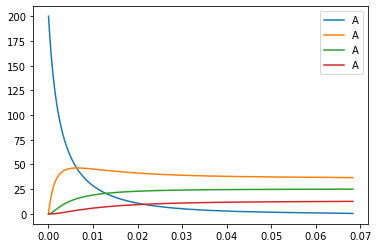

In [20]:
nodes_list = ['A','B','AB']
#nodes_list = ['AB','BMS','ABS','AMS','ABMS','AM','BM','MS']
optim.plot_observable(0,nodes_list)



**After 750 optimization iterations**


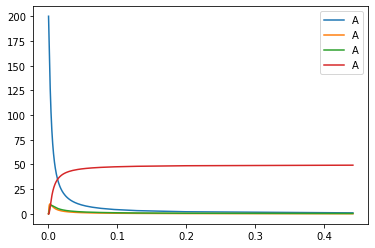

In [21]:

optim.plot_observable(-1,nodes_list)


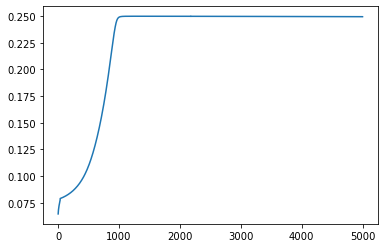

In [22]:
optim.plot_yield()

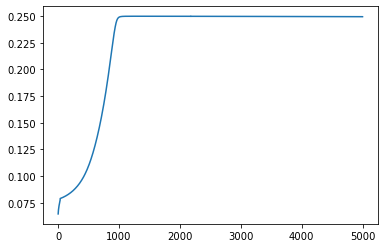

In [23]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(optim.yield_per_iter)

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Using CPU
Next time:  tensor(1258.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
Using CPU
Next time:  tensor(1258.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
Using CPU


No handles with labels found to put in legend.


Next time:  tensor(1258.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
Using CPU
Next time:  tensor(1258.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


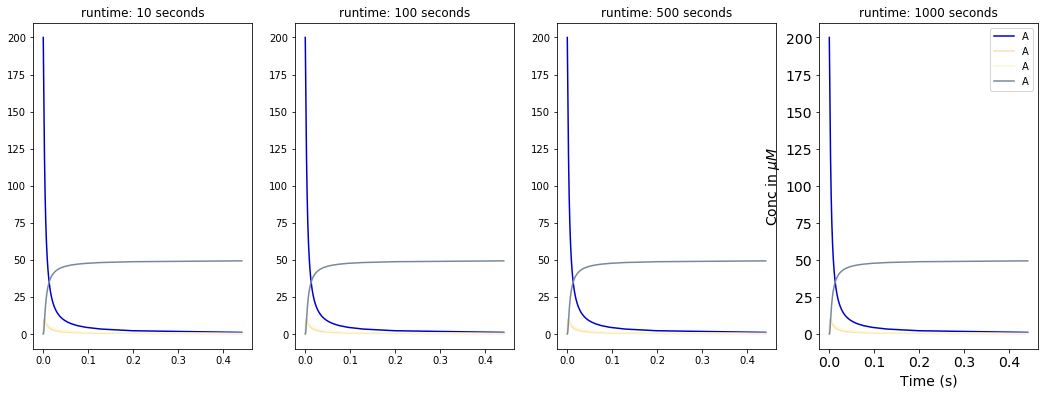

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 4)
optim_rn = optim.rn
for i, runtime in enumerate([10, 100, 500,1000]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i])
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
plt.show()

In [25]:
# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [26]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

tensor([ 0.0771,  0.0000,  0.1209, 49.8901], dtype=torch.float64,
       grad_fn=<MaxBackward2>)
Parameter containing:
tensor([0.3858, 5.1422, 5.3021], dtype=torch.float64, requires_grad=True)


In [27]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

NameError: name 'solution' is not defined

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 